# Description & Methodology
---
**Project Description**

Using NFL data, the goal is to predict whether a pass will be completed. I'll build a classification model utilizing Gradient Boosting Algorithm. 

**Methodology:**
- Gather, clean, and filter data
- Feature engineering
- Prepare random sample
    - Make random samples of different 'eras' and concatenate them together to have a "balanced" sample dataset
- Split sample into Train/Test & Scale
    - Randomly split data into train and test. 15% - 85% ratio.
    - Data transformation: fit scaler using train set. Transform train and test set using scaler 
- Hyper parameter tuning:
    - Use train set to run a Grid Search using cross-validation: the purpose of this step is to find the best parameters to fit the data using my model
- Train model using train set
    - Analyse results: in sample MSE, RMSE, & accuracy or prediction
- Predict test set using previously trained model
    - Analyse results:MSE, RMSE, accuracy or prediction, ROC AUC, Feature Importance
- Compare results to NFL Next Gen Stats model
    - Exlude 2019 from sample
    - Train model using all available data: less or equal 2018
        - Do quick tuning again with Grid Search CV
    - Predict 2019 season and obtain residuals for each indivdual (QB); these are known as Completion Percentage Over Expectation
    - Run a regression between my results and NFL NGS results. Each QB will be an observation
    - Plot results and $R^2$

**Libraries**

In [1]:
# Load packages --
import pandas as pd
import numpy as np
import math
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_val_predict,train_test_split
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,log_loss,r2_score
from sklearn import linear_model
import warnings as wp
wp.filterwarnings("ignore")

# Pre-processing: Data retrieval & cleaning

**Get Data**

In [2]:
#Game data (Lee Sharp data) --
lee_data=pd.read_csv("https://raw.githubusercontent.com/leesharpe/nfldata/master/data/games.csv", low_memory=False)
lee_data=lee_data.loc[lee_data['season'] >= 2006,]
lee_data['temp'].fillna(72,inplace=True)
lee_data['wind'].fillna(lee_data['wind'].min(),inplace=True)
lee_data['game_id'] = lee_data['old_game_id']
lee_data.set_index('game_id',inplace=True)
elev_dic = pd.read_csv('elev_dic.csv').set_index('stadium_id').to_dict()['elevation_feet']
lee_data['elevation'] = lee_data['stadium_id'].map(elev_dic)
temp_dic = lee_data['temp'].to_dict()
roof_dic = lee_data['roof'].to_dict()
wind_dic = lee_data['wind'].to_dict()
elevation_dic = lee_data['elevation'].to_dict()
#Roster Data (nfldastR)--
roster = pd.read_csv('https://raw.githubusercontent.com/guga31bb/nflfastR-data/master/roster-data/roster.csv') 
#Full name dictionary
full_name = roster[['teamPlayers.gsisId','teamPlayers.displayName']].set_index('teamPlayers.gsisId')
full_name=full_name['teamPlayers.displayName'].to_dict()
#Position dictionary
roster.rename(columns={'teamPlayers.positionGroup':'position','teamPlayers.gsisId':'rec_id'},inplace=True)
roster = roster[['rec_id','position']]
roster = roster.drop_duplicates()
roster=roster.set_index('rec_id')
pos_dic=roster.to_dict()['position']

**Lengthy, don't run if not needed, prepared data avilable in repo as ```data_prep.csv```**

In [5]:
#Pplay-by-play (nfldastR) --
years = range(2006,2020)
data = pd.DataFrame()
for i in years:  
    i_data = pd.read_csv(
        'https://github.com/guga31bb/nflfastR-data/blob/master/legacy-data/play_by_play_' + str(i) + '.csv.gz?raw=True',
        compression='gzip', 
        low_memory=False)
    data = data.append(i_data, sort=True)

**Data Mutations**

Don't run if not needed, prepared data avilable in repo as ```data_prep.csv```

In [216]:
data=pd.read_csv(r'C:\Users\adrian-boss\Documents\heavy_data\raw.csv')
#Clean --
data = data[
    (data['play_type'] == 'pass') & 
    (data['epa'].isna()==False) & 
    (data['qb_kneel'] == 0.0) &
    (data['qb_scramble'] == 0.0) &
    (data['qb_spike'] == 0.0) &
    (data['penalty'] == 0.0) &
    (data['sack'] == 0.0)
]
#Merge data
data['rec_pos'] = data['receiver_id'].map(pos_dic)
data['temp']=data['game_id'].map(temp_dic)
data['roof']=data['game_id'].map(roof_dic)
data['wind']=data['game_id'].map(wind_dic)
data['elevation']=data['game_id'].map(elevation_dic)
#Mutations --
data['targ'] = 'OTHER'
for p in ['WR','TE','RB']:
    data.loc[data['rec_pos'] == p,'targ'] = p
data['tipped'] = 0
data.loc[data['desc'].str.contains('tip'),'tipped'] = 1
data["air_is_zero"]= np.where(data["air_yards"]==0, 1, 0)
data['home'] = np.where(data["home_team"] == data["posteam"], 1, 0)
data["2min_warning"]= np.where(data["half_seconds_remaining"]<121, 1, 0)
data["outdoor"]=np.where((data["roof"]=='outdoors') | (data["roof"]=='open'), 1, 0)
data['yardstosticks'] = data['air_yards'] - data['ydstogo'] 
data['era'] = '3'
data.loc[data['season'].isin(range(2006,2013+1)),'era'] = '1'
data.loc[data['season'].isin(range(2014,2017+1)),'era'] = '2'
data['down_3'] = 0
data.loc[data['down'] == 3.0,'down_3'] = 1
data['high'] = 0
data.loc[data['elevation']>=data['elevation'].quantile(q=0.95),'high'] = 1
#Select columns
data=data[['play_id','game_id','passer_player_id','passer_player_name',
       'complete_pass', 'air_yards','qb_hit','yardline_100','pass_location',
       'down','ydstogo','wp','air_is_zero','ep','outdoor','home','tipped','qtr',
       '2min_warning','season','era','targ','elevation','high','temp','wind']]

data.to_csv("data_prep.csv",index=False)

# Analyisis

**Prepare data for analysis: select features, train/test split, scale**

In [314]:
# Read this prepared dataset to save time --
data=pd.read_csv("data_prep.csv")
#Select variables for analysis and drop NAs --
varis=['play_id','game_id','passer_player_id','passer_player_name',
       'complete_pass', 'air_yards','qb_hit','yardline_100','pass_location',
       'down','ydstogo','wp','air_is_zero','ep','outdoor','home','tipped','qtr',
       '2min_warning','season','era','targ']
data=data[varis] 
data=data.dropna()
# Prepare Index --
data['id'] = data['game_id'].astype(str) + '_'+ data['play_id'].astype(str)
data.set_index('id',drop=True,inplace=True)
# Dummies --
t = pd.get_dummies(data['era'],columns='era',prefix='era')
data = pd.concat([data, t], axis=1)
t=pd.get_dummies(data['targ'],columns='targ',prefix='targ')
data=pd.concat([data, t], axis=1)
data.drop(columns=['targ','targ_OTHER'],axis=1,inplace= True)
t=pd.get_dummies(data['down'],columns='down',prefix='down')
data=pd.concat([data, t], axis=1)
data.drop(['down'],axis=1,inplace= True)
t=pd.get_dummies(data['qtr'],columns='qtr',prefix='qtr')
data=pd.concat([data, t], axis=1)
data.drop(['qtr'],axis=1,inplace= True)
t=pd.get_dummies(data['pass_location'],columns='pass',prefix='pass')
data=pd.concat([data, t], axis=1)
data.drop(['pass_location'],axis=1,inplace= True)
# Prepare balanced sample --
era1=data[data['era'] == 1].sample(n=round(50000), replace=False, random_state=4)
era2=data[data['era'] == 2].sample(n=round(55000), replace=False, random_state=9)
era3=data[data['era'] == 3].sample(n=round(35000), replace=False, random_state=12)
sample = pd.concat([era1,era2,era3],axis=0)
sample.drop(['era','game_id','play_id','season', 'passer_player_name','passer_player_id'],axis=1,inplace= True)
# Split train test -- 
Y = sample['complete_pass']
X = sample.drop(columns='complete_pass')
#Drop noisy variables (these were manually taken out during cross validation/tuning phase)
drop = ['era_2','era_3','qtr_1','qtr_2','qtr_3','qtr_4','qtr_5',
        'home','down_1.0','down_4.0','pass_right','pass_left',
        'outdoor','2min_warning']
X.drop(columns=drop,inplace=True)
Y.drop(columns=drop,inplace=True)
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, random_state = 8)
# Features' names --
features = X.columns
#Scale data --
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_test = scaler.transform(x_test)
# Check sample/test size
print('Train: \n{:1,} rows &'.format(x.shape[0]),'{:1,} columns'.format(x.shape[1]))
print('Test: \n{:1,} rows &'.format(x_test.shape[0]),'{:1,} columns'.format(x_test.shape[1]))

Train: 
119,000 rows & 15 columns
Test: 
21,000 rows & 15 columns


**Hyper-Parameter Tunning using Grid Search Cross-validation**

Here I do Grid search cross-validation to find the best parameters.

**Built this to keep track of my Grid searched results**

**Searched**
        
|Parameter|last|last-1|last-2|
|------|------|------|------|
|'min_samples_split'||||
|'min_samples_leaf'||||
|'max_depth'||||
|'n_estimators'||||
|'subsample'||||
|'learning_rate'||||
|Run time ||||

**Results**

|Parameter|Best|Best-1|Best-2
|------|------|------|------|
|'min_samples_split'||||
|'min_samples_leaf'||||
|'max_depth'|||| 
|'n_estimators'||||
|'subsample'||||
|'learning_rate'|||| 

In [196]:
a = datetime.datetime.now()
param_test = {
    'max_depth' : [3,4,5],
    'learning_rate' : [.08,0.1,.12]
            }
# Set grid-search --
gsearch = GridSearchCV(
    GradientBoostingClassifier(
        min_samples_leaf=65,
        min_samples_split=600,
        n_estimators = 80,
        random_state=0,
        max_features='auto',
        subsample= .8
    ), 
    param_grid = param_test, 
    scoring='neg_log_loss',
    n_jobs=-1, 
    cv=3)  
#Run Grid search --
gsearch.fit(x,y)
b = datetime.datetime.now()
print('Run-time:',b - a)
#CV Results
print('Best Parameters:',gsearch.best_params_)

Run-time: 0:02:00.083977
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5}


**CV Results**

In [197]:
# Estimate prob - train set --
ytrain_prob = gsearch.predict_proba(x)[:, 1]
ytrain_hat = gsearch.predict(x)
train=pd.DataFrame(data={'CP':ytrain_prob,'Predicted':ytrain_hat},index=y.index)
train['Outcome'] = y
train['CPOE'] = train['Outcome'] - train['CP']
se_t = train['CPOE']**2
mse_t = se_t.values.mean()
rmse_t = math.sqrt(mse_t)
train_accuracy = accuracy_score(y.values,ytrain_hat)
# Print Results --
print('Gradient Boosting Classifier train accuracy score: \n{:.2%}'.format(train_accuracy))
print('Train RMSE: \n{:.2%}'.format(rmse_t))
print('Train MSE: \n{:.2%}'.format(mse_t))

Gradient Boosting Classifier train accuracy score: 
70.13%
Train RMSE: 
44.56%
Train MSE: 
19.86%


**Test Results**

In [198]:
# Estimate prob - test set --
ytest_prob = gsearch.predict_proba(x_test)[:, 1]
ytest_hat = gsearch.predict(x_test)
test = pd.DataFrame(data={'CP':ytest_prob,'Predicted':ytest_hat},index= y_test.index)
test['Outcome'] = y_test
test['CPOE'] = test['Outcome'] - test['CP']
se = test['CPOE']**2
mse = se.values.mean()
rmse = math.sqrt(mse)
test_accuracy = accuracy_score(y_test.values,ytest_hat)
# Print Results --
print('Gradient Boosting Classifier test accuracy score: \n{:.2%}'.format(test_accuracy,4))
print('Test RMSE: \n{:.2%}'.format(rmse))
print('Test MSE: \n{:.2%}'.format(mse))

Gradient Boosting Classifier test accuracy score: 
69.64%
Test RMSE: 
44.80%
Test MSE: 
20.07%


**ROC AUC Curve**

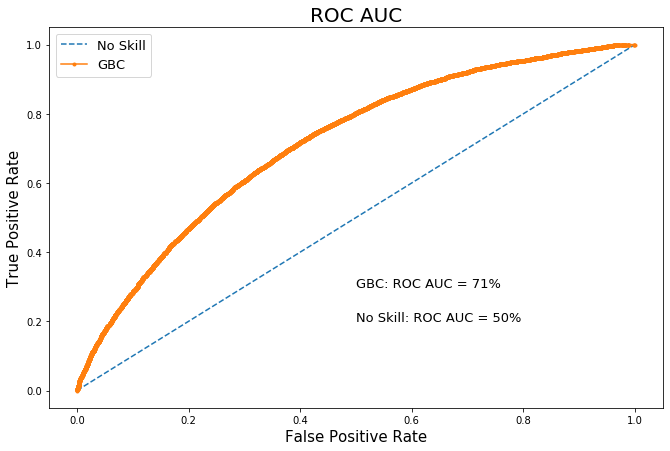

In [321]:
#Code from: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
lr_probs = gsearch.predict_proba(x_test)[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(11,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='GBC')
# axis labels
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
#Legend
plt.legend(loc=2, prop={'size': 13})
#text
plt.text(.5, .3,'GBC: ROC AUC = {:.0%}'.format(lr_auc), fontsize=13)
plt.text(.5, .2,'No Skill: ROC AUC = {:.0%}'.format(ns_auc), fontsize=13)
#Title
plt.title("ROC AUC",fontsize=20)
# show the plot
plt.show()

**Feature Importance**

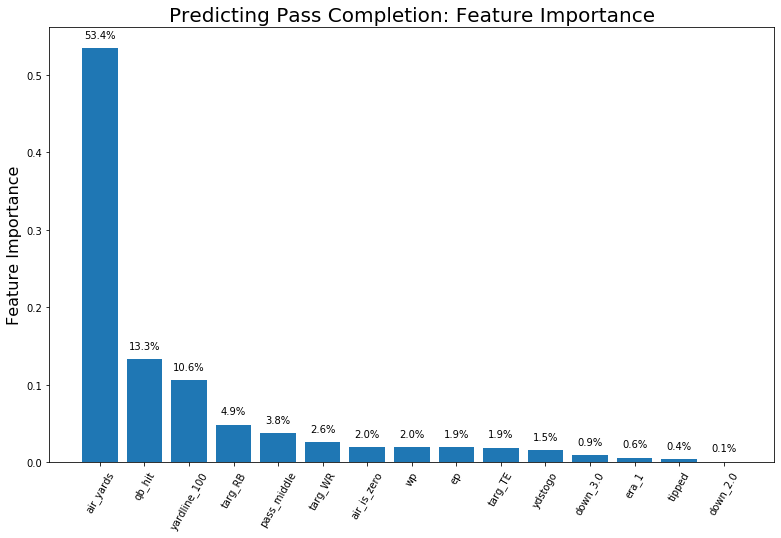

In [311]:
featu = pd.DataFrame(data = {'feat':features,'import':gsearch.best_estimator_.feature_importances_})
featu=featu.sort_values(by='import',ascending=False)
a = featu['feat']
b = featu['import']
plt.figure(figsize=(13,8))
plt.bar(a,b)
# zip joins x and y coordinates in pairs
for a,b in zip(a,b):
    label = "{:.1%}".format(b)
    plt.annotate(label,
                 (a,b), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.title("Predicting Pass Completion: Feature Importance",fontsize=20)
plt.xticks(rotation=60)
plt.ylabel("Feature Importance",fontsize=16)
plt.show()

# Comparing with NFL Next Gen Stats

In this section I'd like to compare how my model would have predicted the NFL 2019 season. I will be comparing my mean errors (CPOE), grouped by level (Quartback) with NFL Next Gen Stats's (NGS) "+/-" variable, Which is escencially the same thing: by how much a QB over or underperformed.    

NGS has tracking data, which means they can add closeness of closest defender, aceleration, mass, ball location, and other key variables into the model. My goal is to explain 90% of NGS results using public data. I'll use $R^2$.

In order to make it as realistic as possible, I'll separate 2019 and re-fit my model, assuming 2006 - 2018 was the only data we have. This would give us realistic and reporducible results moving forward.

From our previous exercise we found good paameters so I'll just do a little cross-val to train based on new data.


**Prepare analysis & Grid search CV**

In [236]:
seas_dic = data['season'].to_dict()
fit_x = data.copy()
# Save passer_id and passer names in a dictionary
dic_names=fit_x[['passer_player_id','passer_player_name']].set_index('passer_player_id').to_dict()['passer_player_name']
dic_passer=fit_x['passer_player_id'].to_dict()
# Split train/test --
pred_x = fit_x[fit_x['season'] == 2019].copy()
pred_y = fit_x['complete_pass'].astype(int)
pred_x.drop(drop_pred,axis=1,inplace= True)
pred_x_index = pred_x.index
fit_x = fit_x[fit_x['season'] <= 2018]
fit_y=fit_x['complete_pass'].astype(int)
# Drop noisy variables --
drop_pred = drop.copy()
drop_pred.extend(['complete_pass','play_id','game_id','passer_player_id','passer_player_name'])
fit_x.drop(drop_pred,axis=1,inplace= True)
#Scale data --
scaler = MinMaxScaler()
fit_x = scaler.fit_transform(fit_x)
pred_x = scaler.transform(pred_x)
# Train model --
a = datetime.datetime.now()
# Set search --
param_test = {
    'max_depth':[4,5],
    'learning_rate':[.1,.12]
}
# Set grid-search --
gsearch2 = GridSearchCV(
    GradientBoostingClassifier(
        min_samples_leaf=65,
        min_samples_split=600,
        n_estimators = 80,
        random_state=0,
        max_features='auto',
        subsample= .8
    ), 
    param_grid = param_test, 
    scoring='neg_log_loss',
    n_jobs=-1, 
    cv=2) 
gsearch2.fit(fit_x,fit_y)
b = datetime.datetime.now()
print('Run-time:',b - a)
print('Best Parameters:',gsearch2.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4}


**Results**

In [237]:
# Estimate Probs --
y_prob = gsearch2.best_estimator_.predict_proba(pred_x)[:, 1]
y_hat = gsearch2.best_estimator_.predict(pred_x)
comp_set = pd.DataFrame(
    data={'CP':y_prob,'Predicted':y_hat.astype(int),'Outcome':pred_y},
    index=pred_x_index
)
# Prepare set --
comp_set['player_id'] = comp_set.index.map(dic_passer)
comp_set['passer_name'] = comp_set['player_id'].map(full_name)
comp_set['CPOE'] = comp_set['Outcome'] - comp_set['CP']
comp_set['Season']=comp_set.index.map(seas_dic)
comp_set = comp_set[comp_set['Season'] == 2019]
# Metrics --
se_c = comp_set['CPOE']**2
mse_c = se_c.values.mean()
rmse_c = math.sqrt(mse_c)
comp_accuracy = accuracy_score(comp_set['Outcome'] ,comp_set['Predicted'] )
print('Gradient Boosting Classifier 2019 accuracy score: \n{:.2%}'.format(comp_accuracy))
print('2019 RMSE: \n{:.2%}'.format(rmse_c))
print('2019 MSE: \n{:.2%}'.format(mse_c))

Gradient Boosting Classifier 2019 accuracy score: 
71.71%
2019 RMSE: 
43.79%
2019 MSE: 
19.17%


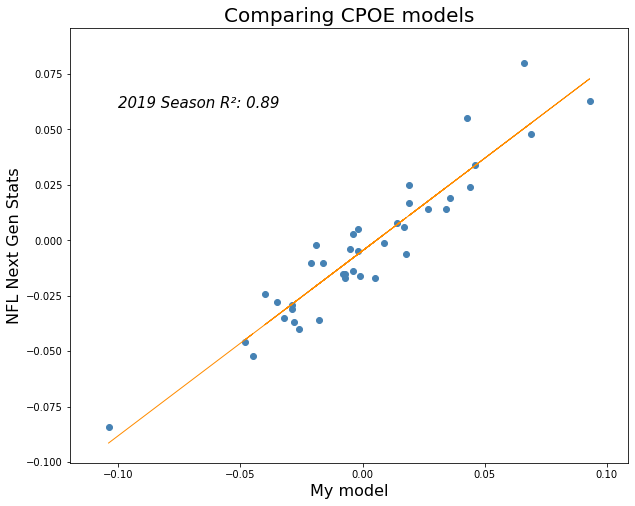

In [325]:
# Summarize by QB
by_qb = comp_set.groupby(
    'player_id').agg(
    {
        'CPOE':'mean',
        'CP':'count', 
        }).rename(columns={'CP':'Num of Attempts'})
by_qb=by_qb[by_qb['Num of Attempts'] >= 100]
by_qb['QB'] = by_qb.index.map(full_name)
# Merge NFL NGS
ngs = pd.read_csv('ngs.csv')
by_qb = by_qb.merge(ngs,on='QB',how='left').dropna()
by_qb=by_qb[['QB','Num of Attempts','CPOE','CPOE_NFL']]
by_qb.sort_values(by='CPOE_NFL',ascending=False,inplace=True)
by_qb['Rank'] = np.arange(1, len(by_qb) + 1)
by_qb.set_index('Rank',inplace=True)
# LM Pred
x_var=by_qb[['CPOE']].round(3)
y_var=by_qb[['CPOE_NFL']]
regr = linear_model.LinearRegression()
regr.fit(x_var,y_var)
y_hat_var = regr.predict(x_var)
# Plot outputs
plt.figure(figsize=(10,8))
plt.scatter(x_var, y_var,  color='steelblue')
plt.plot(x_var, y_hat_var, color='darkorange', linewidth=1)
plt.ylabel('NFL Next Gen Stats',fontsize=16)
plt.xlabel('My model',fontsize=16)
r2 = r2_score(y_var, y_hat_var)
plt.text(-.1, .06,u"2019 Season R\u00b2: {:0.2f}".format(r2), style='italic', fontsize=15)
plt.title("Comparing CPOE models",fontsize=20)
plt.show()

# Conclussion
With 0.89, I was very close to my goal of .90 $R^2$